In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import holidays

In [182]:
STREET = 'washington'

df = pd.read_csv(f'data/{STREET}_merged.csv')

df['time'] = pd.to_datetime(df['time'])

#****************Choisir ici la date de début du dataset*****************
df = df.loc[df['time'] >= '2019-01-01']


print("Number of rows: ", len(df))
print("Columns: ", df.columns)

print("Start date: ", df['time'].min())
print("End date: ", df['time'].max())

Number of rows:  50573
Columns:  Index(['time', 'id_arc', 'id_upstream_node', 'upstream_node',
       'id_downstream_node', 'downstream_node', 'closed_state',
       'traffic_state', 'throughput', 'occupancy'],
      dtype='object')
Start date:  2019-01-01 00:00:00
End date:  2024-12-01 23:00:00


In [183]:
weather_df = pd.read_csv(r'data\cleaned_weather.csv', delimiter=',', index_col=2)
weather_df.index = pd.to_datetime(weather_df.index).date


def concat_prcp(date):
    return weather_df.loc[date, 'PRCP'] if date in weather_df.index else None

def concat_snwd(date):
    return weather_df.loc[date, 'SNWD'] if date in weather_df.index else None

def concat_tmax(date):
    return weather_df.loc[date, 'TMAX'] if date in weather_df.index else None

# Appliquer les fonctions pour ajouter des colonnes à df
df['PRCP'] = df['time'].dt.date.map(lambda x: concat_prcp(x))
df['SNWD'] = df['time'].dt.date.map(lambda x: concat_snwd(x))
df['TMAX'] = df['time'].dt.date.map(lambda x: concat_tmax(x))

In [184]:
df

,time,id_arc,id_upstream_node,upstream_node,id_downstream_node,downstream_node,closed_state,traffic_state,throughput,occupancy,PRCP,SNWD,TMAX
78880,2019-01-01 00:00:00,4264,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,2,1,3.0,0.00000,0.01,0.0,49.0
78881,2019-01-01 01:00:00,4264,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,2,1,1.0,0.00000,0.01,0.0,49.0
78882,2019-01-01 02:00:00,4264,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,2,1,44.0,1.78722,0.01,0.0,49.0
78883,2019-01-01 03:00:00,4264,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,2,1,260.0,5.57611,0.01,0.0,49.0
78884,2019-01-01 04:00:00,4264,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,3,1,790.0,5.35833,0.01,0.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129448,2024-12-01 19:00:00,4264,2294,NaN,2293,Av_Champs_Elysees-Berri,3,2,267.0,20.32556,NaN,NaN,NaN
129449,2024-12-01 20:00:00,4264,2294,NaN,2293,Av_Champs_Elysees-Berri,3,2,306.0,16.92834,NaN,NaN,NaN
129450,2024-12-01 21:00:00,4264,2294,NaN,2293,Av_Champs_Elysees-Berri,3,2,294.0,16.22889,NaN,NaN,NaN
129451,2024-12-01 22:00:00,4264,2294,NaN,2293,Av_Champs_Elysees-Berri,3,1,315.0,12.26611,NaN,NaN,NaN


In [185]:
#Imputer les valeurs manquantes. Peut être amélioré + weather_df s'arrête vers octobre 2024
df['PRCP'] = df['PRCP'].fillna(0)
df['TMAX'] = df['TMAX'].fillna(df['TMAX'].mean())
df['SNWD'] = df['SNWD'].fillna(0)

In [186]:
# Handling missing values (simplest way)

df['throughput'] = df['throughput'].ffill()
df['throughput'] = df['throughput'].bfill()
df['occupancy'] = df['occupancy'].ffill()
df['occupancy'] = df['occupancy'].bfill()

# Remove unnecessary columns
df = df.drop(columns=['id_arc', 'id_upstream_node', 'upstream_node', 'id_downstream_node', 'downstream_node'])

df.isnull().sum()

time             0
closed_state     0
traffic_state    0
throughput       0
occupancy        0
PRCP             0
SNWD             0
TMAX             0
dtype: int64

In [187]:
# Ensure 'time' is datetime
df['time'] = pd.to_datetime(df['time'])

# Extract features
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['week_of_year'] = df['time'].dt.isocalendar().week
df['year'] = df['time'].dt.year

# Define French holidays
fr_holidays = holidays.France()

def is_holiday(date):
    return 1 if date in fr_holidays else 0

df['is_holiday'] = df['time'].dt.date.apply(is_holiday)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >=5 else 0)

In [188]:
# List of feature columns
feature_cols = ['hour', 'day_of_week', 'month', 'day', 'week_of_year', 'year', 'is_weekend', 'PRCP', 'SNWD', 'TMAX', 'is_holiday'] 

# Define target variables
targets = ['throughput', 'occupancy']

cutoff_date = df["time"].max() - pd.DateOffset(months=1, days=8)
max_date  = df["time"].max() - pd.DateOffset(months=1, days=3)

# Training set: Data up to cutoff_date
train_df = df[df['time'] <= cutoff_date]

# Testing set: Data after cutoff_date
test_df = df[(df['time'] > cutoff_date) & (df['time'] <= max_date)]

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Print out the max date in the training set
print(f"Min date in training set: {train_df['time'].min()}")
print(f"Max date in training set: {train_df['time'].max()}")
print(f"Min date in testing set: {test_df['time'].min()}")
print(f"Max date in testing set: {test_df['time'].max()}")

Training data shape: (50079, 16)
Testing data shape: (119, 16)
Min date in training set: 2019-01-01 00:00:00
Max date in training set: 2024-10-24 23:00:00
Min date in testing set: 2024-10-25 00:00:00
Max date in testing set: 2024-10-29 23:00:00


In [189]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Features and target for throughput
X_train_throughput = train_df[feature_cols]
y_train_throughput = train_df['throughput']

X_test_throughput = test_df[feature_cols]
y_test_throughput = test_df['throughput']

# Handle any remaining missing values, if any
X_train_throughput = X_train_throughput.fillna(0)
X_test_throughput = X_test_throughput.fillna(0)

# Initialize the model
rf_throughput = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-2)

# Train the model
rf_throughput.fit(X_train_throughput, y_train_throughput)

# Predict
y_pred_throughput = rf_throughput.predict(X_test_throughput)

# Evaluate
mae_throughput = mean_absolute_error(y_test_throughput, y_pred_throughput)
rmse_throughput = np.sqrt(mean_squared_error(y_test_throughput, y_pred_throughput))
print(f'Throughput - MAE: {mae_throughput}, RMSE: {rmse_throughput}')

Throughput - MAE: 76.19087565446101, RMSE: 99.82454216150158


In [190]:
# Features and target for occupancy
X_train_occupancy = train_df[feature_cols]
y_train_occupancy = train_df['occupancy']

X_test_occupancy = test_df[feature_cols]
y_test_occupancy = test_df['occupancy']

# Handle any remaining missing values, if any
X_train_occupancy = X_train_occupancy.fillna(0)
X_test_occupancy = X_test_occupancy.fillna(0)

# Initialize the model
rf_occupancy = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-2)

# Train the model
rf_occupancy.fit(X_train_occupancy, y_train_occupancy)

# Predict
y_pred_occupancy = rf_occupancy.predict(X_test_occupancy)

# Evaluate
mae_occupancy = mean_absolute_error(y_test_occupancy, y_pred_occupancy)
rmse_occupancy = np.sqrt(mean_squared_error(y_test_occupancy, y_pred_occupancy))
print(f'Occupancy - MAE: {mae_occupancy}, RMSE: {rmse_occupancy}')

Occupancy - MAE: 8.689682326539623, RMSE: 9.722837990731154


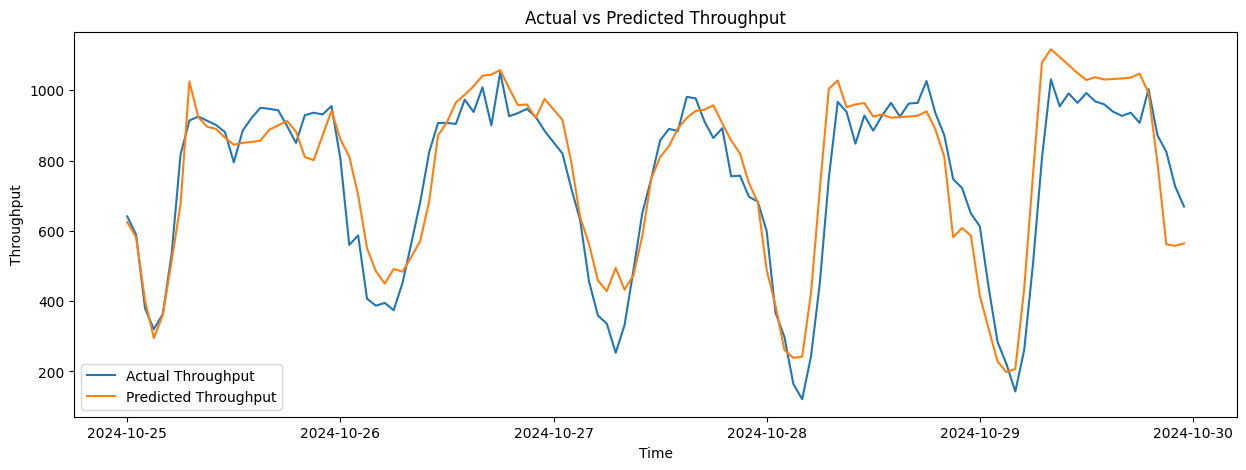

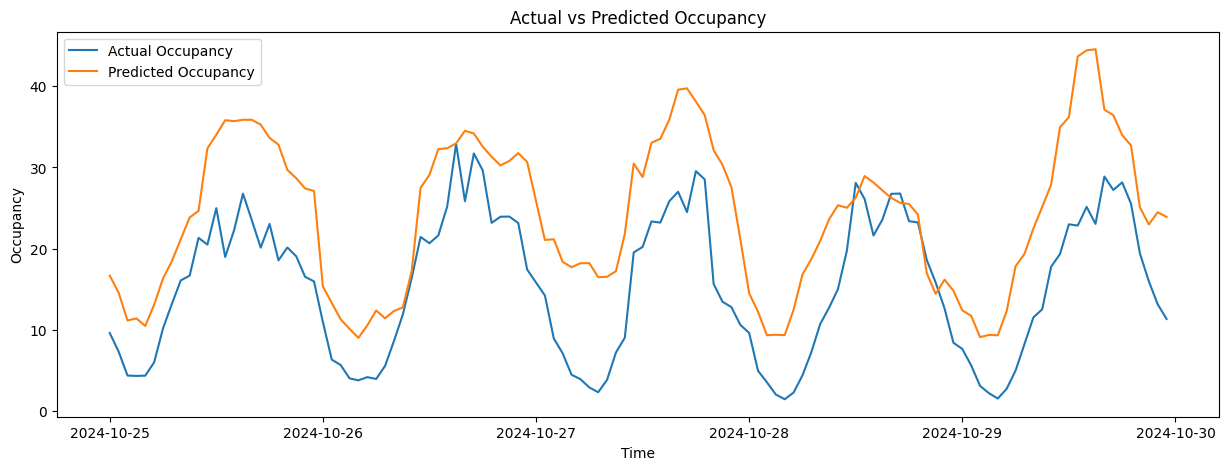

In [191]:
import matplotlib.pyplot as plt

# Plot for Throughput
plt.figure(figsize=(15,5))
plt.plot(test_df['time'], y_test_throughput, label='Actual Throughput')
plt.plot(test_df['time'], y_pred_throughput, label='Predicted Throughput')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Throughput')
plt.title('Actual vs Predicted Throughput')
plt.show()

# Plot for Occupancy
plt.figure(figsize=(15,5))
plt.plot(test_df['time'], y_test_occupancy, label='Actual Occupancy')
plt.plot(test_df['time'], y_pred_occupancy, label='Predicted Occupancy')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.title('Actual vs Predicted Occupancy')
plt.show()

In [192]:
from prophet import Prophet

df_throughput = df[['time', 'throughput']].rename(columns={'time': 'ds', 'throughput': 'y'})
df_occupancy = df[['time', 'occupancy']].rename(columns={'time': 'ds', 'occupancy': 'y'})

In [193]:
def is_holiday(date):
    return 1 if date in fr_holidays else 0

def is_weekend(day_of_week):
    return 1 if day_of_week >= 5 else 0

# Add 'is_holiday' and 'is_weekend' to both dataframes
for df_forecast in [df_throughput, df_occupancy]:
    df_forecast['is_holiday'] = df_forecast['ds'].dt.date.apply(is_holiday)
    df_forecast['day_of_week'] = df_forecast['ds'].dt.dayofweek
    df_forecast['is_weekend'] = df_forecast['day_of_week'].apply(is_weekend)
    df_forecast['PRCP'] = df['time'].dt.date.map(lambda x: concat_prcp(x))
    df_forecast['SNWD'] = df['time'].dt.date.map(lambda x: concat_snwd(x))
    df_forecast['TMAX'] = df['time'].dt.date.map(lambda x: concat_tmax(x))

    df_forecast['PRCP'] = df_forecast['PRCP'].fillna(0)
    # Remplir TMAX avec la moyenne
    df_forecast['TMAX'] = df_forecast['TMAX'].fillna(df_forecast['TMAX'].mean())
    # Remplir SNWD avec 0
    df_forecast['SNWD'] = df_forecast['SNWD'].fillna(0)




In [194]:
df_occupancy

,ds,y,is_holiday,day_of_week,is_weekend,PRCP,SNWD,TMAX
78880,2019-01-01 00:00:00,0.00000,1,1,0,0.01,0.0,49.000000
78881,2019-01-01 01:00:00,0.00000,1,1,0,0.01,0.0,49.000000
78882,2019-01-01 02:00:00,1.78722,1,1,0,0.01,0.0,49.000000
78883,2019-01-01 03:00:00,5.57611,1,1,0,0.01,0.0,49.000000
78884,2019-01-01 04:00:00,5.35833,1,1,0,0.01,0.0,49.000000
...,...,...,...,...,...,...,...,...
129448,2024-12-01 19:00:00,20.32556,0,6,1,0.00,0.0,64.502892
129449,2024-12-01 20:00:00,16.92834,0,6,1,0.00,0.0,64.502892
129450,2024-12-01 21:00:00,16.22889,0,6,1,0.00,0.0,64.502892
129451,2024-12-01 22:00:00,12.26611,0,6,1,0.00,0.0,64.502892


In [195]:
# From 1st October 2024 to 5th October 2024
cutoff_date = pd.to_datetime('2024-10-01')
max_date  = pd.to_datetime('2024-10-06')

train_throughput = df_throughput[df_throughput['ds'] <= cutoff_date]
test_throughput = df_throughput[(df_throughput['ds'] > cutoff_date) & (df_throughput['ds'] <= max_date)]

train_occupancy = df_occupancy[df_occupancy['ds'] <= cutoff_date]
test_occupancy = df_occupancy[(df_occupancy['ds'] > cutoff_date) & (df_occupancy['ds'] <= max_date)]

print(f"Throughput Training Data: {train_throughput.shape}")
print(f"Throughput Testing Data: {test_throughput.shape}")

print(f"Occupancy Training Data: {train_occupancy.shape}")
print(f"Occupancy Testing Data: {test_occupancy.shape}")

Throughput Training Data: (49504, 8)
Throughput Testing Data: (120, 8)
Occupancy Training Data: (49504, 8)
Occupancy Testing Data: (120, 8)


In [196]:
FIT_PROPHET = True

In [197]:
if FIT_PROPHET:
    # Initialize Prophet model
    model_throughput = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='additive',
        holidays=None  # We'll add regressors manually
    )

    # Add external regressors
    model_throughput.add_regressor('is_weekend')
    model_throughput.add_regressor('is_holiday')
    model_throughput.add_regressor('PRCP')
    model_throughput.add_regressor('SNWD')
    model_throughput.add_regressor('TMAX')

    # Fit the model
    model_throughput.fit(train_throughput)

17:53:42 - cmdstanpy - INFO - Chain [1] start processing
17:55:58 - cmdstanpy - INFO - Chain [1] done processing


In [198]:
if FIT_PROPHET:
    # Initialize Prophet model
    model_occupancy = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='additive',
        holidays=None  # We'll add regressors manually
    )

    # Add external regressors
    model_occupancy.add_regressor('is_weekend')
    model_occupancy.add_regressor('is_holiday')
    model_occupancy.add_regressor('PRCP')
    model_occupancy.add_regressor('SNWD')
    model_occupancy.add_regressor('TMAX')

    # Fit the model
    model_occupancy.fit(train_occupancy)

17:56:25 - cmdstanpy - INFO - Chain [1] start processing
17:58:07 - cmdstanpy - INFO - Chain [1] done processing


In [203]:
# Define the forecast period
future_start = cutoff_date + pd.Timedelta(hours=1)  # Start right after the training period
future_end = max_date

future_dates = pd.date_range(start=future_start, end=future_end, freq='H')

future_throughput = pd.DataFrame({'ds': future_dates})
future_occupancy = pd.DataFrame({'ds': future_dates})

# Function to add external regressors to a future DataFrame
def add_external_regressors(df_future):
    # is_weekend
    df_future['day_of_week'] = df_future['ds'].dt.dayofweek
    df_future['is_weekend'] = df_future['day_of_week'].apply(lambda x: 1 if x >=5 else 0)
    df_future['is_holiday'] = df_future['ds'].dt.date.apply(is_holiday)
    df_future['PRCP'] = df_future['ds'].dt.date.map(lambda x: concat_prcp(x))
    df_future['SNWD'] = df_future['ds'].dt.date.map(lambda x: concat_snwd(x))
    df_future['TMAX'] = df_future['ds'].dt.date.map(lambda x: concat_tmax(x))
    return df_future

# Add external regressors
future_throughput = add_external_regressors(future_throughput)
future_occupancy = add_external_regressors(future_occupancy)

C:\Users\pierr\AppData\Local\Temp\ipykernel_7568\3896788619.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=future_start, end=future_end, freq='H')


In [204]:
if FIT_PROPHET:
    forecast_throughput = model_throughput.predict(future_throughput)
    display(forecast_throughput[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

    forecast_occupancy = model_occupancy.predict(future_occupancy)
    display(forecast_occupancy[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

,ds,yhat,yhat_lower,yhat_upper
0,2024-10-01 01:00:00,600.459751,264.688597,927.811637
1,2024-10-01 02:00:00,521.440496,202.273121,836.007465
2,2024-10-01 03:00:00,403.318887,63.851323,720.802411
3,2024-10-01 04:00:00,297.599169,-41.943797,625.680534
4,2024-10-01 05:00:00,272.987396,-31.151229,579.579293


,ds,yhat,yhat_lower,yhat_upper
0,2024-10-01 01:00:00,16.104051,4.562063,27.819997
1,2024-10-01 02:00:00,14.313917,2.732152,25.985780
2,2024-10-01 03:00:00,12.158803,1.148183,23.882890
3,2024-10-01 04:00:00,10.378298,-1.213713,21.625589
4,2024-10-01 05:00:00,9.744360,-1.437817,20.937843


In [205]:
if FIT_PROPHET:
    test_throughput = test_throughput.rename(columns={'throughput': 'y'})
    test_throughput = add_external_regressors(test_throughput)

    test_occupancy = test_occupancy.rename(columns={'occupancy': 'y'})
    test_occupancy = add_external_regressors(test_occupancy)

    forecast_test_throughput = model_throughput.predict(test_throughput)
    forecast_test_occupancy = model_occupancy.predict(test_occupancy)

    # Throughput Evaluation
    mae_throughput = mean_absolute_error(test_throughput['y'], forecast_test_throughput['yhat'])
    rmse_throughput = np.sqrt(mean_squared_error(test_throughput['y'], forecast_test_throughput['yhat']))

    print(f'Throughput - MAE: {mae_throughput:.2f}, RMSE: {rmse_throughput:.2f}')

    # Occupancy Evaluation
    mae_occupancy = mean_absolute_error(test_occupancy['y'], forecast_test_occupancy['yhat'])
    rmse_occupancy = np.sqrt(mean_squared_error(test_occupancy['y'], forecast_test_occupancy['yhat']))

    print(f'Occupancy - MAE: {mae_occupancy:.2f}, RMSE: {rmse_occupancy:.2f}')

Throughput - MAE: 245.35, RMSE: 300.46
Occupancy - MAE: 4.60, RMSE: 5.71


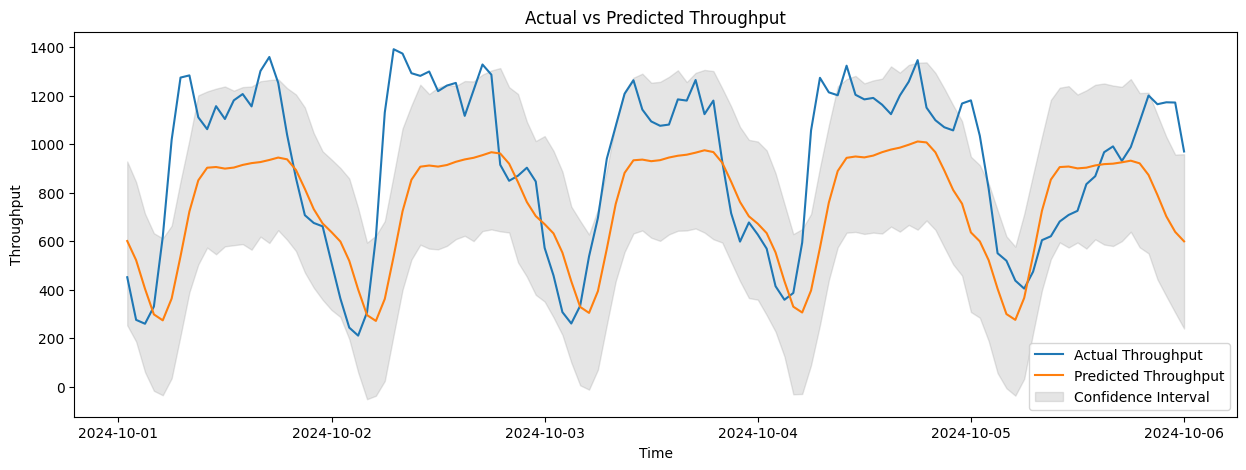

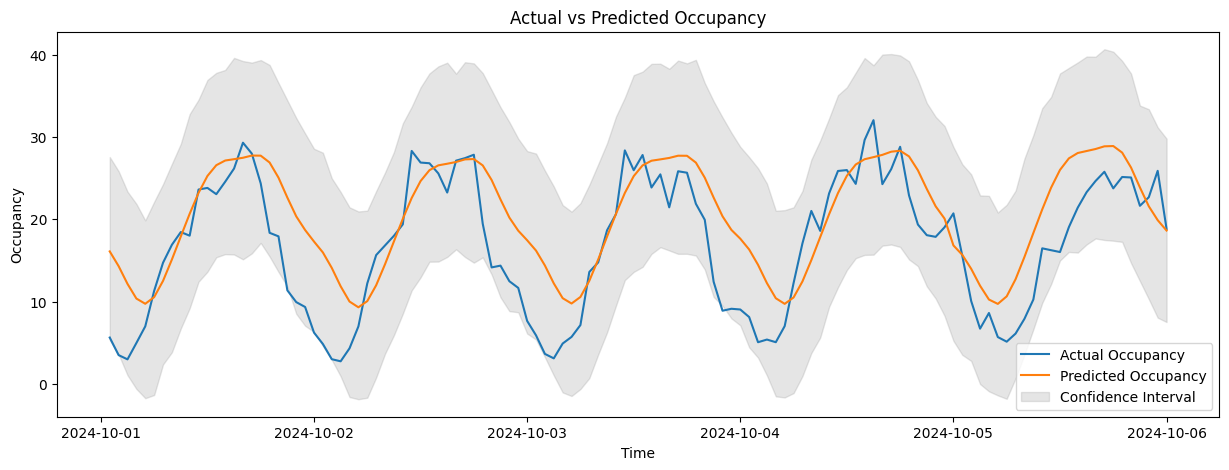

In [206]:
if FIT_PROPHET:
    # Throughput Plot
    plt.figure(figsize=(15,5))
    plt.plot(test_throughput['ds'], test_throughput['y'], label='Actual Throughput')
    plt.plot(forecast_test_throughput['ds'], forecast_test_throughput['yhat'], label='Predicted Throughput')
    plt.fill_between(forecast_test_throughput['ds'], 
                    forecast_test_throughput['yhat_lower'], 
                    forecast_test_throughput['yhat_upper'], 
                    color='gray', alpha=0.2, label='Confidence Interval')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Throughput')
    plt.title('Actual vs Predicted Throughput')
    plt.show()

    # Occupancy Plot
    plt.figure(figsize=(15,5))
    plt.plot(test_occupancy['ds'], test_occupancy['y'], label='Actual Occupancy')
    plt.plot(forecast_test_occupancy['ds'], forecast_test_occupancy['yhat'], label='Predicted Occupancy')
    plt.fill_between(forecast_test_occupancy['ds'], 
                    forecast_test_occupancy['yhat_lower'], 
                    forecast_test_occupancy['yhat_upper'], 
                    color='gray', alpha=0.2, label='Confidence Interval')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Occupancy')
    plt.title('Actual vs Predicted Occupancy')
    plt.show()